In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
from scipy.stats import mode
from scipy import stats
import feather
import re
import warnings
import random

from IPython.display import clear_output

In [7]:
target = pd.read_csv('target2',header=None,index_col=0)

In [8]:
train = feather.read_dataframe('best_table\\train')
test = feather.read_dataframe('best_table\\test')

In [4]:
groupped = feather.read_dataframe('cats and percent spent\\groupped_table') 

train = pd.merge(train,groupped,how='left',on='card_id')
test = pd.merge(test,groupped,how='left',on='card_id')

In [5]:
train.head()

,auth_purchase_amount_min,last_months_purchase_max,1to2_rel_mean,agged_au_purchase_date_months_week_std,auth_purchase_amount_sum,month_lag_mean,all_month_pos__15,hist_month_lag_std,auth_days_activity_max,all_month_fbte__9_prc,4to5_rel_mean,all_months_distance_between_purchases_median,new_month_diff_mean,id5_percent_of_purchases,mi_card_id_add_mode,new_merchant_category_id_nunique,1to2_rel_gen_mean,new_category_3_B_mean,all_purchases_max_percent,hist_month_lag_mean,6to7_rel_gen_mean,hist_purchase_date_max,all_month_pos__6_prc,purchase_amount_sum_std,id6_percent_of_purchases,4to5_rel_gen_mean,authorized_flag_mean,agged_non_debt_until_month_mean,id9_percent_of_purchases,7th_month_debt_bte_sum,elapsed_time,all_month_fetb__7_prc,purchase_amount_mean_mean,agged_au_purchase_amount_min,new_purchase_month_std,hist_purchase_amount_max,mi_merchant_category_id_mean,all_month_pos__8_prc,0to1_rel_mean,author_purchases_min_percent,purchase_amount_std_mean,new_days_activity_max,auth_purchase_date_ptp,non_author_purchases_mean,auth_purchase_amount_mean,purchase_amount_min_std,5to6_rel_mean,purchase_amount_std_std,all_month_fbte__6_prc,feature_1,subsector_id_mean,agged_au_category_1_mean,installments_std_std,city_id_purchase_amount_mean,ml_au_month_lag_mean_PM,all_month_pos__10_prc,7th_month_debt_bte_mean,id10_percent_of_purchases,ml_all_month_lag_mean_PM,auth_month_lag_mean,agged_non_purchase_amount_sum,mcicard_id_min,last_payments_month,2to3_rel_mean,all_purch_per_hour__13_prc,all_purchases_skew,3to4_rel_mean,5th_month_debt_bte_sum,all_month_fbte__0_prc,3to4_rel_gen_mean,installments_purchase_amount_max,8th_month_debt_bte_sum,all_month_fbte__4_prc,hist_purchase_amount_min,last_months_purchase_max_percent,author_purchases_skew,eb_non_purchase_amount_count_std_PM,auth_merchant_id_nunique,all_month_fetb__1_prc,category_1_purchase_amount_min,id3_percent_of_purchases,all_month_fbte__5_prc,agged_au_month_lag_mean,agged_au_city_id_modeplus,installments_count_mean,auth_month_lag_std,hist_purchase_date_ptp,agged_au_purchase_years_day_ptp,purchase_amount_max_std,state_id_std,agged_all_category_1_mean,length_of_activity_in_mpnths,5th_month_debt_bte_mean,all_month_pos__15_prc,mcimerchant_id_percent_to_mc_id_std,all_day_2_num_of_purch_prc,author_purchases_max_percent,all_month_pos__16_prc,mcicard_id_mean,agged_au_merchant_category_id_modeplus,installments_purchase_amount_min,id11_percent_of_purchases,auth_category_3_C_mean,all_month_pos__14_prc,agged_au_purchase_date_year_mean,new_month_lag_mean,auth_purchase_date_min,city_id_purchase_amount_max,subsector_id_std,agged_au_category_1_sum,4th_month_debt_bte_sum,mi_card_id_percent_to_merchid_std,hist_purchase_date_min,mcicard_id_std,all_month_pos__9_prc,new_category_1_mean,new_purchase_amount_sum,hist_purchase_amount_sum,2to3_rel_gen_mean,agged_non_valid_authorization_percent_max,agged_all_purchase_date_year_mean,agged_non_purchase_date_hour_std,auth_quartal_3_mean,6th_month_debt_bte_mean,all_purchases_mean_percent,agged_non_city_id_modeplus,new_purchases_per_month_mean,author_purchases_mean_percent,agged_all_city_id_modeplus,agged_all_merchant_category_id_modeplus,agged_all_category_1_sum,new_purchase_amount_std,new_purchase_date_min,new_purchase_date_ptp,new_purchase_date_max,all_month_fetb__1,agged_all_purchase_date_day_max,agged_non_payment_per_month_sum,0to1_rel_gen_mean,auth_month_diff_mean,agged_au_purchase_date_day_max,hist_month_diff_mean,purchase_amount_max_mean,agged_non_merchant_category_id_modeplus,last_payments_day,auth_purchase_date_max,new_purchase_month_mean,new_purchase_amount_max,card_id,category_combined_without_cat1_modeplus,category_combined_without_cat1_top_quarter_quantile,category_combined_without_cat1_bottom_quarter_quantile,category_combined_without_cat1_std,category_combined_with_cat1_modeplus,category_combined_with_cat1_top_quarter_quantile,category_combined_with_cat1_bottom_quarter_quantile,category_combined_with_cat1_std,average_purchase_per_day,average_purchase_per_unique_day
0

In [9]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month','last_active_month']]
categorical_feats = [x for x in features if (re.search('modeplus',x) or re.search('feature_',x))] + [x for x in features if re.search('[th]_cat1_[^s]',x)]

In [10]:
warnings.filterwarnings("ignore")
for col in [x for x in train2 if x!='card_id']:
    train[col] = train2[col]
    best_score = 3.65474
    features = [c for c in train.columns if c not in ['card_id', 'first_active_month','last_active_month']]
    categorical_feats = [x for x in features if (re.search('modeplus',x) or re.search('feature_',x))] #+ [x for x in features if re.search('[th]_cat1_[^s]',x)]
    
    
    param = {
            'num_leaves': 111, #checked
             'num_threads': 4,
             'max_bin': 170, #checked 170
             'min_data_in_leaf': 100, #checked 100
             'objective':'regression',
             'max_depth': 9, #checked
             'tree_learner':'data',
             'learning_rate': 0.07,
             "boosting": "gbdt", #dart, gbdt
             "feature_fraction": 0.9, #checked
             "bagging_freq": 5, #5
             "bagging_fraction": 0.9, #checked
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.26, #checked 26
    #            'lambda_l2': 0.3, #checked
             "random_state": 77,
             "verbosity": -1,
             "device":"gpu",
             'gpu_device_id':0,
             'gpu_platform_id':1,
             'gpu_use_dp':True,
            }


    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    start = time.time()
    feature_importance_df = pd.DataFrame()

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        print("fold n°{}".format(fold_))

        trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                               label=target.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(train.iloc[val_idx][features],
                               label=target.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )


        clf = lgb.train(param, trn_data,10000, valid_sets = [trn_data, val_data], verbose_eval=250, early_stopping_rounds = 200)

        oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

#        predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    errr = mean_squared_error(oof, target)**0.5
#    print("CV score: {:<8.5f}".format(errr))
    if errr > best_score:
        train.drop(col,axis=1,inplace=True)
        print('adds noise')
    else:
        best_score = errr
        print('a good column')
    
    print("CV score: {:<8.5f}\n0.{} - column\n".format(errr,col))
    
    #test 3.65598    n3 3.78153
    #0.90 frac: 3.64632  3.77624
    #0.75 frac: 3.64450  

NameError: name 'train2' is not defined

In [10]:
train.head()

,auth_purchase_amount_min,last_months_purchase_max,1to2_rel_mean,agged_au_purchase_date_months_week_std,auth_purchase_amount_sum,month_lag_mean,all_month_pos__15,hist_month_lag_std,auth_days_activity_max,all_month_fbte__9_prc,4to5_rel_mean,all_months_distance_between_purchases_median,new_month_diff_mean,id5_percent_of_purchases,mi_card_id_add_mode,new_merchant_category_id_nunique,1to2_rel_gen_mean,new_category_3_B_mean,all_purchases_max_percent,hist_month_lag_mean,6to7_rel_gen_mean,hist_purchase_date_max,all_month_pos__6_prc,purchase_amount_sum_std,id6_percent_of_purchases,4to5_rel_gen_mean,authorized_flag_mean,agged_non_debt_until_month_mean,id9_percent_of_purchases,7th_month_debt_bte_sum,elapsed_time,all_month_fetb__7_prc,purchase_amount_mean_mean,agged_au_purchase_amount_min,new_purchase_month_std,hist_purchase_amount_max,mi_merchant_category_id_mean,all_month_pos__8_prc,0to1_rel_mean,author_purchases_min_percent,purchase_amount_std_mean,new_days_activity_max,auth_purchase_date_ptp,non_author_purchases_mean,auth_purchase_amount_mean,purchase_amount_min_std,5to6_rel_mean,purchase_amount_std_std,all_month_fbte__6_prc,feature_1,subsector_id_mean,agged_au_category_1_mean,installments_std_std,city_id_purchase_amount_mean,ml_au_month_lag_mean_PM,all_month_pos__10_prc,7th_month_debt_bte_mean,id10_percent_of_purchases,ml_all_month_lag_mean_PM,auth_month_lag_mean,agged_non_purchase_amount_sum,mcicard_id_min,last_payments_month,2to3_rel_mean,all_purch_per_hour__13_prc,all_purchases_skew,3to4_rel_mean,5th_month_debt_bte_sum,all_month_fbte__0_prc,3to4_rel_gen_mean,installments_purchase_amount_max,8th_month_debt_bte_sum,all_month_fbte__4_prc,hist_purchase_amount_min,last_months_purchase_max_percent,author_purchases_skew,eb_non_purchase_amount_count_std_PM,auth_merchant_id_nunique,all_month_fetb__1_prc,category_1_purchase_amount_min,id3_percent_of_purchases,all_month_fbte__5_prc,agged_au_month_lag_mean,agged_au_city_id_modeplus,installments_count_mean,auth_month_lag_std,hist_purchase_date_ptp,agged_au_purchase_years_day_ptp,purchase_amount_max_std,state_id_std,agged_all_category_1_mean,length_of_activity_in_mpnths,5th_month_debt_bte_mean,all_month_pos__15_prc,mcimerchant_id_percent_to_mc_id_std,all_day_2_num_of_purch_prc,author_purchases_max_percent,all_month_pos__16_prc,mcicard_id_mean,agged_au_merchant_category_id_modeplus,installments_purchase_amount_min,id11_percent_of_purchases,auth_category_3_C_mean,all_month_pos__14_prc,agged_au_purchase_date_year_mean,new_month_lag_mean,auth_purchase_date_min,city_id_purchase_amount_max,subsector_id_std,agged_au_category_1_sum,4th_month_debt_bte_sum,mi_card_id_percent_to_merchid_std,hist_purchase_date_min,mcicard_id_std,all_month_pos__9_prc,new_category_1_mean,new_purchase_amount_sum,hist_purchase_amount_sum,2to3_rel_gen_mean,agged_non_valid_authorization_percent_max,agged_all_purchase_date_year_mean,agged_non_purchase_date_hour_std,auth_quartal_3_mean,6th_month_debt_bte_mean,all_purchases_mean_percent,agged_non_city_id_modeplus,new_purchases_per_month_mean,author_purchases_mean_percent,agged_all_city_id_modeplus,agged_all_merchant_category_id_modeplus,agged_all_category_1_sum,new_purchase_amount_std,new_purchase_date_min,new_purchase_date_ptp,new_purchase_date_max,all_month_fetb__1,agged_all_purchase_date_day_max,agged_non_payment_per_month_sum,0to1_rel_gen_mean,auth_month_diff_mean,agged_au_purchase_date_day_max,hist_month_diff_mean,purchase_amount_max_mean,agged_non_merchant_category_id_modeplus,last_payments_day,auth_purchase_date_max,new_purchase_month_mean,new_purchase_amount_max,card_id
0,-0.739395,11.0,1.051026,1.302837,-157.397016,-4.000000,12.0,1.664101,243,0.042403,1.047633,379.5,9.782609,0.187682,350.0,14.0,0.879227,0.000000,0.201413,-4.461538,0.851629,1.514385e+09,0.010601,10.015655,0.169598,0.168581,0.950000,9.846154,0.159102,0.000000,245.0,0.070671,-0.650482,22.606055,0.510754,-0.431922,14.032491,0.155477,0.984306,0.010601,0.109584,55.0,20977987.0,1.181818,-0.637235,0.008797,1.0049

In [ ]:
#3.65830  3.78166 no   mode 0.75 with_add
#3.65750  3.78065 with mode 0.75 with_add
#3.65545  3.78512 no   mode 0.9 with_add
#3.65498  3.78472 with mode 0.9 with_add

#3.65791  3.77967 0.75
#3.65474  3.77925 0.90

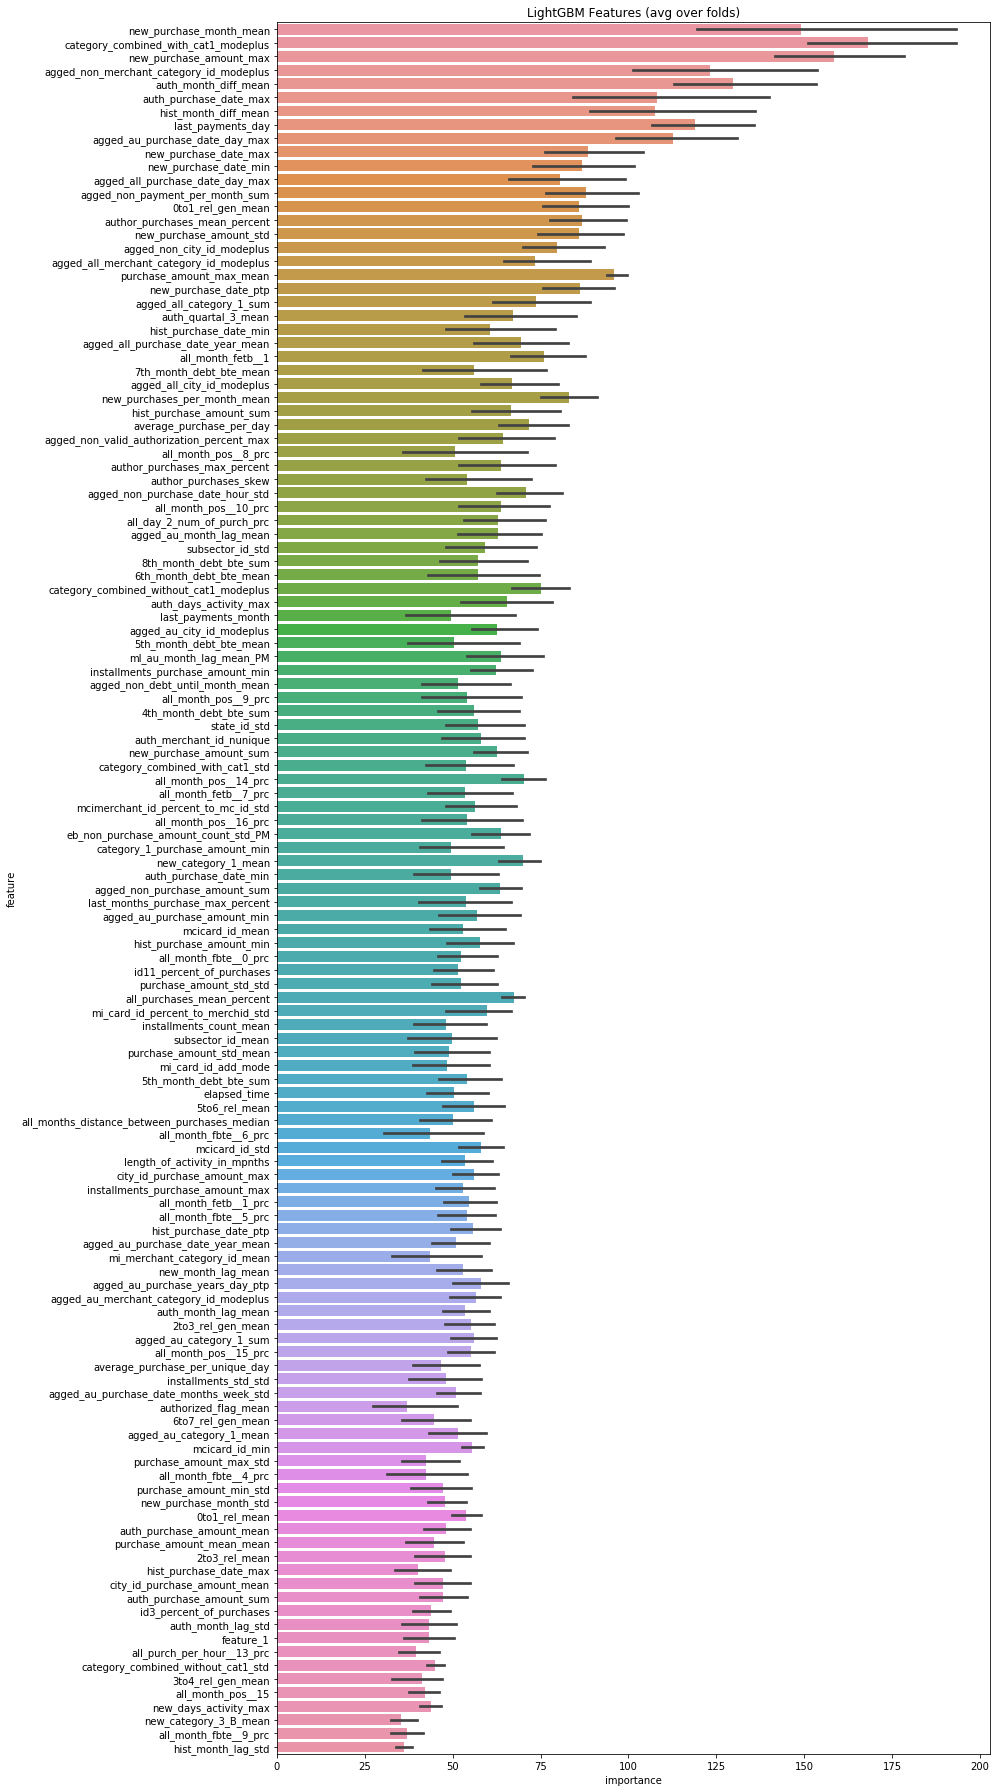

In [46]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [47]:
all_cols = pd.DataFrame(best_features.groupby(['feature'])['importance'].mean()).sort_values(by='importance')
all_cols

,importance
feature,
new_category_3_B_mean,35.2
hist_month_lag_std,36.2
authorized_flag_mean,37.0
all_month_fbte__9_prc,37.0
all_purch_per_hour__13_prc,39.6
hist_purchase_date_max,40.0
3to4_rel_gen_mean,41.4
all_month_pos__15,42.0
purchase_amount_max_std,42.4


In [48]:
best_cols = all_cols[all_cols.importance > 40].index

In [49]:
del best_cols